# ENGR 400-001 Project 1: Estimating Blood Pressure from EKG
### Imports

In [218]:
import numpy as np
import pandas as pd

import h5py             # Used to read the .mat files

import heartpy as hp    # Used to analyze EKG and PPG data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns

### Function to label the data

In [219]:
def getBPcatagory(ABP, SBParray, DBParray):      # Input: ABP timeseries, Systolic blood pressure indecies, Disastolic blood pressure indecies | Output: Classification label
    SBP = 0
    DBP = 0

    for i in SBParray:
        SBP = SBP + ABP[i]

    for i in DBParray:
        DBP = DBP + ABP[i]

    SBP = SBP / len(SBParray)
    DBP = DBP / len(DBParray)

    if SBP < 120 and DBP < 80:
        return "normal"
    elif SBP < 140 and DBP < 90:
        return "prehypertension"
    elif SBP < 160 and DBP < 100:
        return "hypertension1"
    else:
        return "hypertension2"



### Function to generate feature table from data

In [220]:
def generateFeatures(f, d, fa, da):         # Input: File, Dataset, Annotation File, Annotation Dataset | Output: Dataframe(Feature Table)
    ft = pd.DataFrame(columns=["bpm", "ibi", "sdnn", "sdsd", "rmssd", "pnn20", "pnn50", "hr_mad", "sd1", "sd2", "s", "sd1/sd2", "breathingrate", "bloodpressure"])
    for i in range(0, 3000):
        PPG = np.ndarray.transpose(np.array(f[d[i][0]]))[0]     # PPG timeseries data
        ABP = np.ndarray.transpose(np.array(f[d[i][0]]))[1]     # ABP timeseries data
        EKG = np.ndarray.transpose(np.array(f[d[i][0]]))[2]     # EKG timeseries data

        SBP = np.ndarray.transpose(np.array(fa[da[i][0]], dtype=np.int64))[1]   # Systolic blood pressure indecies in ABP timeseries
        DBP = np.ndarray.transpose(np.array(fa[da[i][0]], dtype=np.int64))[0]   # Diastolic blood pressure indecies in ABP timeseries

        try:
            _, PPGmeasurements = hp.process(PPG, 125)
            _, EKGmeasurements = hp.process(EKG, 125)

            df = pd.DataFrame()
            for m in PPGmeasurements.keys():
                df.at[1,m] = (PPGmeasurements[m] + EKGmeasurements[m]) / 2
            
            df["bloodpressure"] = getBPcatagory(ABP, SBP, DBP)
            
            ft = ft.append(df)

        except:
            ft = ft.append(pd.Series(), ignore_index=True)

    return ft

In [221]:
DATASET_DIRECTORY = "BP Dataset\\"      # Directory that datasets and annotations are stored in
FILE_1 = h5py.File(DATASET_DIRECTORY + "Part_1.mat", "r")
FILE_2 = h5py.File(DATASET_DIRECTORY + "Part_2.mat", "r")
FILE_3 = h5py.File(DATASET_DIRECTORY + "Part_3.mat", "r")
FILE_4 = h5py.File(DATASET_DIRECTORY + "Part_4.mat", "r")

FILE_1_ANNOTATION = h5py.File(DATASET_DIRECTORY + "Part_1_Annotation.mat", "r")
FILE_2_ANNOTATION = h5py.File(DATASET_DIRECTORY + "Part_2_Annotation.mat", "r")
FILE_3_ANNOTATION = h5py.File(DATASET_DIRECTORY + "Part_3_Annotation.mat", "r")
FILE_4_ANNOTATION = h5py.File(DATASET_DIRECTORY + "Part_4_Annotation.mat", "r")

DATASET_1 = FILE_1["Part_1"]
DATASET_2 = FILE_2["Part_2"]
DATASET_3 = FILE_3["Part_3"]
DATASET_4 = FILE_4["Part_4"]

DATASET_1_ANNOTATION = FILE_1_ANNOTATION["Part_1_Annotation"]
DATASET_2_ANNOTATION = FILE_2_ANNOTATION["Part_2_Annotation"]
DATASET_3_ANNOTATION = FILE_3_ANNOTATION["Part_3_Annotation"]
DATASET_4_ANNOTATION = FILE_4_ANNOTATION["Part_4_Annotation"]

# This generates the features and target from the four files and then appends them into one dataframe
FT = generateFeatures(FILE_1, DATASET_1, FILE_1_ANNOTATION, DATASET_1_ANNOTATION).append(generateFeatures(FILE_2, DATASET_2, FILE_2_ANNOTATION, DATASET_2_ANNOTATION)).append(generateFeatures(FILE_3, DATASET_3, FILE_3_ANNOTATION, DATASET_3_ANNOTATION)).append(generateFeatures(FILE_4, DATASET_4, FILE_4_ANNOTATION, DATASET_4_ANNOTATION))

# Eliminate rows of data with NaN
FT = FT.replace([np.inf, -np.inf], np.nan).dropna()

X = FT.drop(["bloodpressure"], axis=1)
y = FT["bloodpressure"]

C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\numpy\ma\core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\pandas\core\dtypes\missing.py:531: UserWarning: Warning: converting a masked element to nan.
  val = np.array(val, copy=False)
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\pandas\core\internals\blocks.py:954: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approx

### Feature analysis to determine which features are the most useful

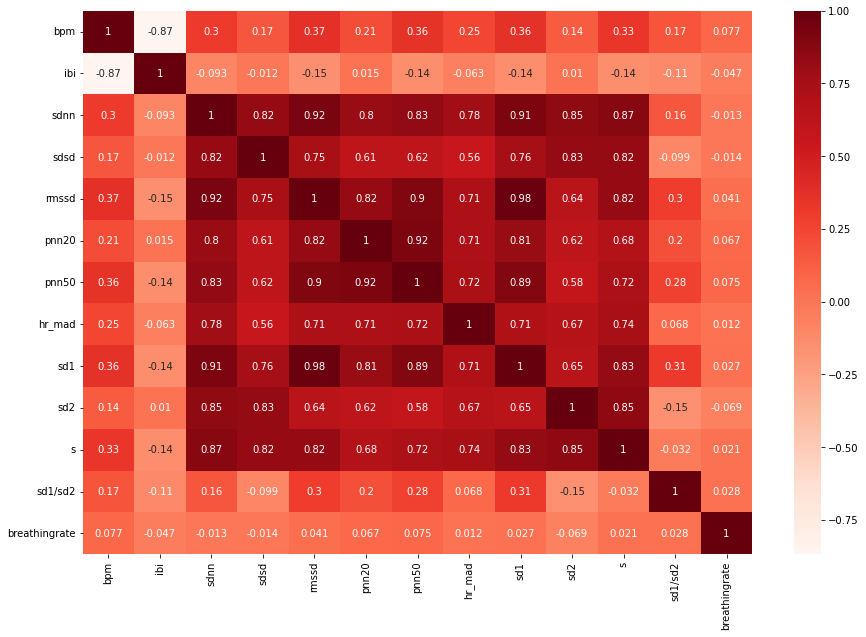

In [222]:
# Chi squared feature selection
X_3  = SelectKBest(chi2, k=3).fit_transform(X, y)
X_5  = SelectKBest(chi2, k=5).fit_transform(X, y)
X_10 = SelectKBest(chi2, k=10).fit_transform(X, y)

# Display pearson coefficient
plt.figure(figsize=(15, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

### Creating testing and training sets and scaling the data

In [223]:
# This is assuming that the data is sufficiently randomized
trainingIndex = int(len(X_3) * .7)
testIndex = len(X_3)

X_3_train = X_3[0 : trainingIndex]
X_3_test = X_3[trainingIndex+1:testIndex]

X_5_train = X_5[0 : trainingIndex]
X_5_test = X_5[trainingIndex+1:testIndex]

X_10_train = X_10[0 : trainingIndex]
X_10_test = X_10[trainingIndex+1:testIndex]

y_train = y[0 : trainingIndex]
y_test = y[trainingIndex+1 : testIndex]

# Applying standard scaler to each test set
scaler_3 = StandardScaler()
scaler_3.fit(X_3_train)
X_3_scaled_train = scaler_3.transform(X_3_train)
X_3_scaled_test = scaler_3.transform(X_3_test)

scaler_5 = StandardScaler()
scaler_5.fit(X_5_train)
X_5_scaled_train = scaler_5.transform(X_5_train)
X_5_scaled_test = scaler_5.transform(X_5_test)

scaler_10 = StandardScaler()
scaler_10.fit(X_10_train)
X_10_scaled_train = scaler_10.transform(X_10_train)
X_10_scaled_test = scaler_10.transform(X_10_test)

### Training models

In [224]:
logReg_3  = LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.1, multi_class='ovr').fit(X_3_train, y_train)
logReg_5  = LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.1, multi_class='ovr').fit(X_5_train, y_train)
logReg_10 = LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.1, multi_class='ovr').fit(X_10_train, y_train)

knn_3  = KNeighborsClassifier().fit(X_3_train, y_train)
knn_5  = KNeighborsClassifier().fit(X_5_train, y_train)
knn_10 = KNeighborsClassifier().fit(X_10_train, y_train)

svm_3  = svm.SVC().fit(X_3_train, y_train)
svm_5  = svm.SVC().fit(X_5_train, y_train)
svm_10 = svm.SVC().fit(X_10_train, y_train)

rfc_3  = RandomForestClassifier().fit(X_3_train, y_train)
rfc_5  = RandomForestClassifier().fit(X_5_train, y_train)
rfc_10 = RandomForestClassifier().fit(X_10_train, y_train)

### Performance evaluation

In [225]:
logRegPred_3  = logReg_3.predict(X_3_test)
logRegPred_5  = logReg_5.predict(X_5_test)
logRegPred_10 = logReg_10.predict(X_10_test)

knnPred_3  = knn_3.predict(X_3_test)
knnPred_5  = knn_5.predict(X_5_test)
knnPred_10 = knn_10.predict(X_10_test)

svmPred_3  = svm_3.predict(X_3_test)
svmPred_5  = svm_5.predict(X_5_test)
svmPred_10 = svm_10.predict(X_10_test)

rfcPred_3  = rfc_3.predict(X_3_test)
rfcPred_5  = rfc_5.predict(X_5_test)
rfcPred_10 = rfc_10.predict(X_10_test)

logAccuracy_3 = accuracy_score(y_test, logRegPred_3)
logPrecision_3 = precision_score(y_test, logRegPred_3, average="macro")
logRecall_3 = recall_score(y_test, logRegPred_3, average="macro")

logAccuracy_5 = accuracy_score(y_test, logRegPred_5)
logPrecision_5 = precision_score(y_test, logRegPred_5, average="macro")
logRecall_5 = recall_score(y_test, logRegPred_5, average="macro")

logAccuracy_10 = accuracy_score(y_test, logRegPred_10)
logPrecision_10 = precision_score(y_test, logRegPred_10, average="macro")
logRecall_10 = recall_score(y_test, logRegPred_10, average="macro")

knnAccuracy_3 = accuracy_score(y_test, knnPred_3)
knnPrecision_3 = precision_score(y_test, knnPred_3, average="macro")
knnRecall_3 = recall_score(y_test, knnPred_3, average="macro")

knnAccuracy_5 = accuracy_score(y_test, knnPred_5)
knnPrecision_5 = precision_score(y_test, knnPred_5, average="macro")
knnRecall_5 = recall_score(y_test, knnPred_5, average="macro")

knnAccuracy_10 = accuracy_score(y_test, knnPred_10)
knnPrecision_10 = precision_score(y_test, knnPred_10, average="macro")
knnRecall_10 = recall_score(y_test, knnPred_10, average="macro")

svmAccuracy_3 = accuracy_score(y_test, svmPred_3)
svmPrecision_3 = precision_score(y_test, svmPred_3, average="macro")
svmRecall_3 = recall_score(y_test, svmPred_3, average="macro")

svmAccuracy_5 = accuracy_score(y_test, svmPred_5)
svmPrecision_5 = precision_score(y_test, svmPred_5, average="macro")
svmRecall_5 = recall_score(y_test, svmPred_5, average="macro")

svmAccuracy_10 = accuracy_score(y_test, svmPred_10)
svmPrecision_10 = precision_score(y_test, svmPred_10, average="macro")
svmRecall_10 = recall_score(y_test, svmPred_10, average="macro")

rfcAccuracy_3 = accuracy_score(y_test, rfcPred_3)
rfcPrecision_3 = precision_score(y_test, rfcPred_3, average="macro")
rfcRecall_3 = recall_score(y_test, rfcPred_3, average="macro")

rfcAccuracy_5 = accuracy_score(y_test, rfcPred_5)
rfcPrecision_5 = precision_score(y_test, rfcPred_5, average="macro")
rfcRecall_5 = recall_score(y_test, rfcPred_5, average="macro")

rfcAccuracy_10 = accuracy_score(y_test, rfcPred_10)
rfcPrecision_10 = precision_score(y_test, rfcPred_10, average="macro")
rfcRecall_10 = recall_score(y_test, rfcPred_10, average="macro")

C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\123ja\Anaconda3\envs\py3x\lib\site-packages\sklearn\met

### Visualization of results

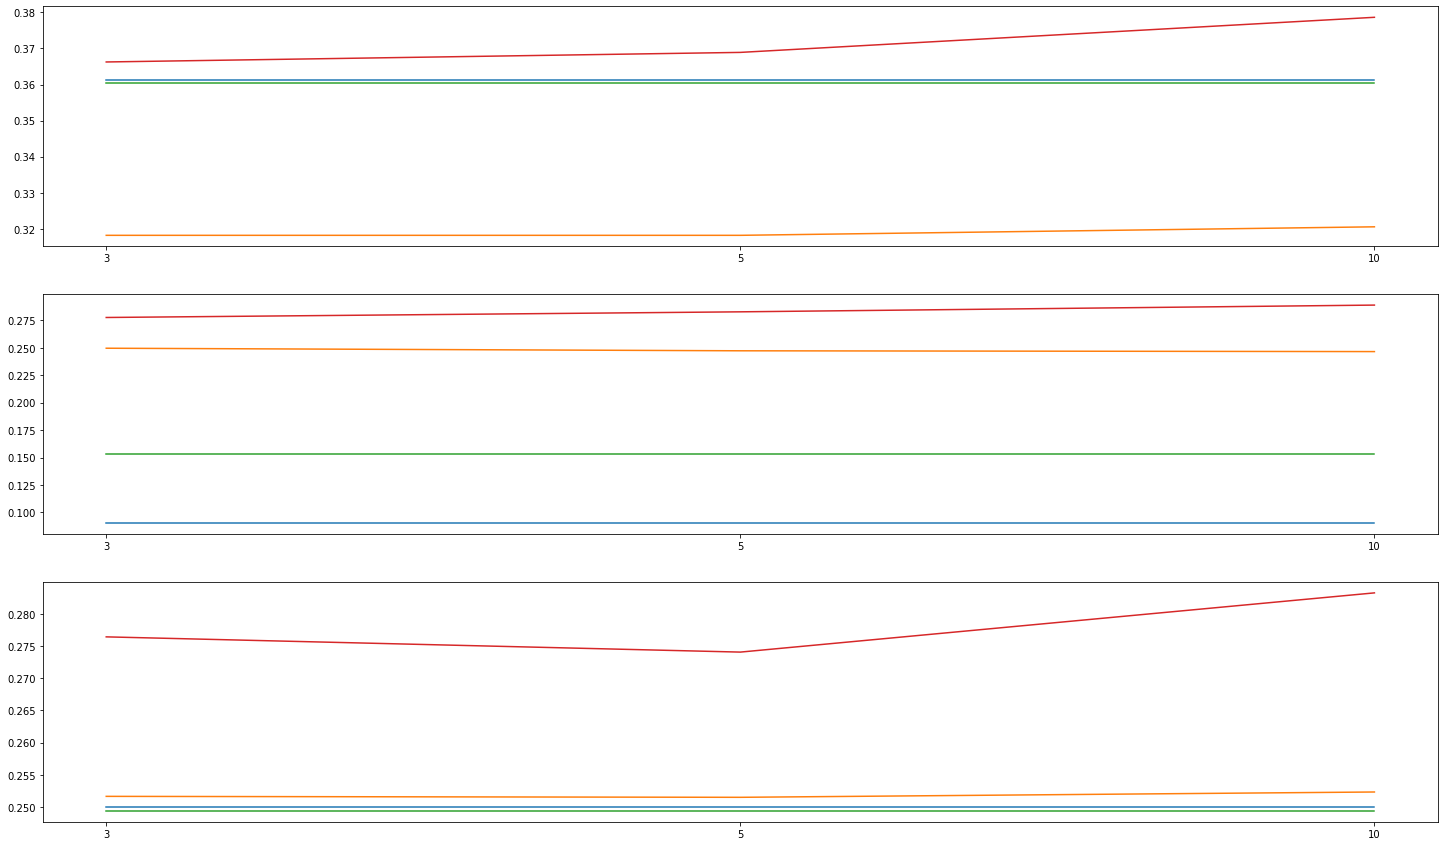

In [226]:
logAccuracy = [logAccuracy_3, logAccuracy_5, logAccuracy_10]
logPrecision = [logPrecision_3, logPrecision_5, logPrecision_10]
logRecall = [logRecall_3, logRecall_5, logRecall_10]

knnAccuracy = [knnAccuracy_3, knnAccuracy_5, knnAccuracy_10]
knnPrecision = [knnPrecision_3, knnPrecision_5, knnPrecision_10]
knnRecall = [knnRecall_3, knnRecall_5, knnRecall_10]

svmAccuracy = [svmAccuracy_3, svmAccuracy_5, svmAccuracy_10]
svmPrecision = [svmPrecision_3, svmPrecision_5, svmPrecision_10]
svmRecall = [svmRecall_3, svmRecall_5, svmRecall_10]

rfcAccuracy = [rfcAccuracy_3, rfcAccuracy_5, rfcAccuracy_10]
rfcPrecision = [rfcPrecision_3, rfcPrecision_5, rfcPrecision_10]
rfcRecall = [rfcRecall_3, rfcRecall_5, rfcRecall_10]

fig = plt.figure(figsize=(25,15))
plt.subplot(3,1,1)
plt.plot(["3", "5", "10"], logAccuracy)
plt.plot(["3", "5", "10"], knnAccuracy)
plt.plot(["3", "5", "10"], svmAccuracy)
plt.plot(["3", "5", "10"], rfcAccuracy)

plt.subplot(3,1,2)
plt.plot(["3", "5", "10"], logPrecision)
plt.plot(["3", "5", "10"], knnPrecision)
plt.plot(["3", "5", "10"], svmPrecision)
plt.plot(["3", "5", "10"], rfcPrecision)

plt.subplot(3,1,3)
plt.plot(["3", "5", "10"], logRecall)
plt.plot(["3", "5", "10"], knnRecall)
plt.plot(["3", "5", "10"], svmRecall)
plt.plot(["3", "5", "10"], rfcRecall)